In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_18\Project.toml`


In [2]:
using TrajectoryOptimization
using RobotDynamics
const RD = RobotDynamics
import RobotZoo.Cartpole
using StaticArrays
using SparseArrays
using LinearAlgebra
using ForwardDiff
using PyPlot
using OSQP

In [3]:
model = Cartpole()
n,m = size(model);

In [4]:
N = 101
Tf = 5.
h = Tf/(N-1)

0.05

In [5]:
x0 = @SVector zeros(n)
xf = @SVector [0, pi, 0, 0];  # i.e. swing up

In [6]:
# Set up
Q = 1.0*Diagonal(@SVector ones(n))
Qf = 100.0*Diagonal(@SVector ones(n))
R = 0.1*Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N);

In [7]:
# Create Empty ConstraintList
conSet = ConstraintList(n,m,N)

# Control Bounds
u_bnd = 5.0
bnd = BoundConstraint(n,m, u_min=-u_bnd, u_max=u_bnd)
add_constraint!(conSet, bnd, 1:N-1)

# Goal Constraint
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, (N-5):N)

In [8]:
# prob = Problem(model, obj, xf, Tf, x0=x0, constraints=conSet);
prob = Problem(model, obj, x0, Tf, xf=xf, constraints=conSet);

In [9]:
u0 = @SVector fill(0.0,m)
U0 = [u0 for k = 1:N-1]
initial_controls!(prob, U0)
rollout!(prob);

In [10]:
using Altro

In [11]:
opts = SolverOptions(
    cost_tolerance_intermediate=1e-3,
    penalty_scaling=10.,
    penalty_initial=1.0
)

altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 205
    Solve Time: 1740.4397 (ms)

  Covergence
    Terminal Cost: 928.317996972354
    Terminal dJ: 0.04853163702932761
    Terminal gradient: 9.07219858099095e-6
    Terminal constraint violation: 4.63767647396196e-7
    Solve Status: SOLVE_SUCCEEDED


In [12]:
# Extract the solution
Xopt = states(altro);
Uopt = controls(altro);

xnom = zeros(n,N)
for k = 1:N
    xnom[:,k] .= Xopt[k]
end

unom = zeros(m,N-1)
utraj = zeros(m,N-1)
for k = 1:N-1
    unom[:,k] .= Uopt[k]
    utraj[:,k] .= Uopt[k]
end

In [13]:
function dynamics_rk4(x, u)
    #RK4 integration with zero-order hold on u
    f1 = RD.dynamics(model, x, u)
    f2 = RD.dynamics(model, x + 0.5*h*f1, u)
    f3 = RD.dynamics(model, x + 0.5*h*f2, u)
    f4 = RD.dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

#True model with friction
function true_dynamics(model::Cartpole, x, u)
    #Perturb masses of cart + pole
    mc = model.mc + 0.02
    mp = model.mp - 0.01
    
    #Perturb length of pendulum
    l = model.l + 0.005
    g = model.g

    q = x[ @SVector [1,2] ]
    qd = x[ @SVector [3,4] ]

    s = sin(q[2])
    c = cos(q[2])

    H = @SMatrix [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = @SMatrix [0 -mp*qd[2]*l*s; 0 0]
    G = @SVector [0, mp*g*l*s]
    B = @SVector [1, 0]
    
    F = [0.01; 0.01].*tanh.(5.0*qd) #nonlinear friction (≈Coulomb/stiction)

    qdd = -H\(C*qd + F + G - B*u[1])
    return [qd; qdd]
end

function true_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = true_dynamics(model, x, u)
    f2 = true_dynamics(model, x + 0.5*h*f1, u)
    f3 = true_dynamics(model, x + 0.5*h*f2, u)
    f4 = true_dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

true_dynamics_rk4 (generic function with 1 method)

In [14]:
#Compute A and B matrices using nominal dynamics + trajectory
A = zeros(n,n,N-1)
B = zeros(n,m,N-1)
for k = 1:(N-1)
    A[:,:,k] .= ForwardDiff.jacobian(x->dynamics_rk4(x,Uopt[k]),Xopt[k])
    B[:,:,k] .= ForwardDiff.jacobian(u->dynamics_rk4(Xopt[k],u),Uopt[k])
end

In [15]:
#Compute LQR Tracking Controller
P = zeros(n,n,N)
K = zeros(m,n,N-1)
P[:,:,N] = Qf
for k = (N-1):-1:1
    K[:,:,k] .= (R + B[:,:,k]'*P[:,:,k+1]*B[:,:,k])\(B[:,:,k]'*P[:,:,k+1]*A[:,:,k])
    P[:,:,k] .= Q + K[:,:,k]'*R*K[:,:,k] + (A[:,:,k]-B[:,:,k]*K[:,:,k])'*P[:,:,k+1]*(A[:,:,k]-B[:,:,k]*K[:,:,k])
end

In [16]:
#Rollout with true dynamics
xtraj = zeros(n,N)
for k = 1:(N-1)
    utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k]-xnom[:,k]) #with LQR tracking controller
    utraj[:,k] .= min.(u_bnd, max.(-u_bnd, utraj[:,k])) #clip values within torque limits
    xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
end

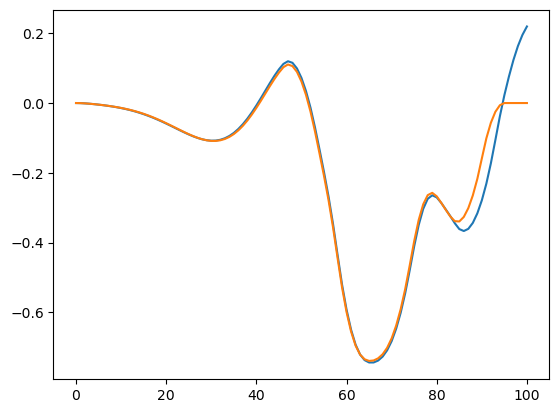

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000075A772B0>

In [17]:
plot(xtraj[1,:])
plot(xnom[1,:])

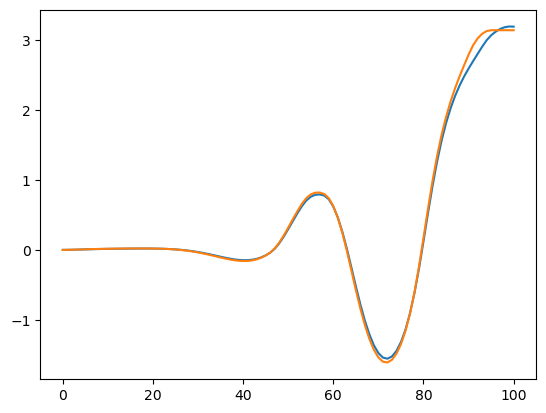

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000226E050>

In [18]:
plot(xtraj[2,:])
plot(xnom[2,:])

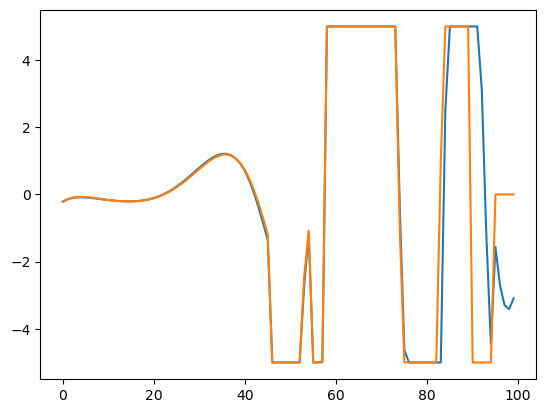

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000020A3790>

In [19]:
plot(utraj[1,:])
plot(Uopt[:])

In [20]:
#Build matrices for ILC QP
Nh = N
#Cost
Qilc = sparse(Diagonal([0.01; 0; 1.0; 0]))
Rilc = sparse(Diagonal([.1]))
H = blockdiag(kron(I(Nh-2), blockdiag(Rilc, Qilc)), Rilc, sparse(Qf))
q = zeros((n+m)*(Nh-1))
for k = 1:(Nh-2)
    q[(k-1)*(m+n) .+ (1:(m+n))] .= [0.0; Qilc*(xtraj[:,k+1]-Xopt[k+1])]
end
q[(Nh-2)*(m+n) .+ (1:(m+n))] .= [0.0; Qf*(xtraj[:,Nh]-Xopt[Nh])]

#Constraints
U = kron(I(Nh-1), [I zeros(m,n)]) #Matrix that picks out all u
X = kron(I(Nh-1), [zeros(n,m) I]) #Matrix that picks out all x
D = spzeros(n*(Nh-1), (n+m)*(Nh-1)) #dynamics constraints

D[1:n,1:m] .= B[:,:,1]
D[1:n,(m+1):(m+n)] .= -I(n)
for k = 1:(Nh-2)
    D[(k*n).+(1:n), (m+(k-1)*(n+m)).+(1:(2*n+m))] .= [A[:,:,k+1] B[:,:,k+1] -I]
end

lb = [zeros(n*(Nh-1)); -u_bnd.-utraj[1:(Nh-1)]]
ub = [zeros(n*(Nh-1)); u_bnd.-utraj[1:(Nh-1)]]

qp = OSQP.Model()
OSQP.setup!(qp, P=H, q=q, A=[D; U], l=lb, u=ub, eps_abs=1e-6, eps_rel=1e-6, eps_prim_inf = 1.0e-6, eps_dual_inf = 1.0e-6, polish=1)
results = OSQP.solve!(qp)
ztraj = results.x;

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 500, constraints m = 500
          nnz(P) + nnz(A) = 2489
settings: linear system solver = qdldl,
          eps_abs = 1.0e-006, eps_rel = 1.0e-006,
          eps_prim_inf = 1.0e-006, eps_dual_inf = 1.0e-006,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter  objective    pri res    dua res    rho        time
   1 -1.0283e+001  2.02e-001  2.47e+001  1.00e-001  3.86e-004s
 100 -1.3324e+001  4.30e-007  2.25e-006  1.00e-001  1.41e-003s
plsh -1.3324e+001  1.11e-016  2.36e-015 

In [21]:
Δu = U*ztraj
utraj[1:(Nh-1)] .= utraj[1:(Nh-1)]+Δu

100-element view(::Vector{Float64}, 1:100) with eltype Float64:
 -0.30355209209618556
 -0.20819194665351784
 -0.13887623407225938
 -0.08930898716509966
 -0.055018270755171544
 -0.03289774095990575
 -0.020824014344449443
 -0.017341641834779778
 -0.02140227579181321
 -0.032149968802474865
 -0.04874888689740328
 -0.07025162448679219
 -0.09550661995914281
  ⋮
  3.9947343189131077
  3.7563536484419426
  3.4815498643019414
  3.403811193221636
  1.6484612101080045
 -2.3930288826744586
 -5.0
 -1.9660276257863245
 -2.7365504260425313
 -2.9701352101054024
 -2.748384721176663
 -2.083753345925393